In [ ]:
#------------------------------------------------
# ESTE CODIGO FUE EL ELEGIDO PARA ENVIARSE A LA PRUEBA MLSP2025 PARA LA TASK2 DE SAMPLEO ESCOGIDO
# EL MÉTODO ESCOGIDO DE SAMPLEO FUE UNA FIGURA RADIAL MUY SIMILAR A LA RUEDA DE UNA BICICLETA, DIO MEJORES RESULTADOS PERO SE PUEDEN PROBAR INVESTIGAR EN ESTA FORMA DE MUESTREO DEBIDO A LA NATURALEZA EXPASIVA DE LAS ANTENAS
# LAS RECOMENDACIONES PARA MEJORAR SON SIMILARES A LAS DEL TASK1

import os
import json
import cv2
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Montar Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive2', force_remount=True)

# ----------------------------------------------
#  Parámetros y rutas
# ----------------------------------------------
dataset_root = "/content/drive2/MyDrive/ICASSP2025_Dataset"
with open(os.path.join(dataset_root, 'extremos.json'), 'r') as f:
    data = json.load(f)

ext_in   = {'min': tuple(data['rgb_min']), 'max': tuple(data['rgb_max'])}
ext_out  = {'min': data['pl_min'],      'max': data['pl_max']}
inputs_path  = os.path.join(dataset_root, "Inputs/Task_2_ICASSP")
outputs_path = os.path.join(dataset_root, "Outputs/Task_2_ICASSP")

# CoordConv channels precomputadas
coords = np.linspace(-1, 1, 512)
grid_y, grid_x = np.meshgrid(coords, coords, indexing='ij')
coord_channels = np.stack([grid_x, grid_y], axis=-1)  # (512,512,2)

# ----------------------------------------------
#  Funciones de preprocesado con offset
# ----------------------------------------------
def pad_crop_to_512_with_offset(img, pad_value=0):
    H, W = img.shape[:2]
    # vertical
    if H >= 512:
        y0 = (H - 512)//2
        img512 = img[y0:y0+512, :]
        off_y = -y0
    else:
        pt = (512 - H)//2; pb = 512 - H - pt
        img512 = cv2.copyMakeBorder(img, pt, pb, 0, 0,
                                     cv2.BORDER_CONSTANT, value=pad_value)
        off_y = pt
    # horizontal
    H2, W2 = img512.shape[:2]
    if W2 >= 512:
        x0 = (W2 - 512)//2
        img512 = img512[:, x0:x0+512]
        off_x = -x0
    else:
        pl = (512 - W2)//2; pr = 512 - W2 - pl
        img512 = cv2.copyMakeBorder(img512, 0, 0, pl, pr,
                                     cv2.BORDER_CONSTANT, value=pad_value)
        off_x = pl
    return img512, (off_x, off_y)

def normalize_rgb(img, ext):
    img = img.astype(np.float32)
    (minR, minG, minB), (maxR, maxG, maxB) = ext['min'], ext['max']
    R = (img[...,0] - minR) / (maxR - minR)
    G = (img[...,1] - minG) / (maxG - minG)
    B = (img[...,2] - minB) / (maxB - minB)
    return np.clip(np.stack([R, G, B], axis=-1), 0, 1)

def normalize_gray(img, ext):
    img = img.astype(np.float32)
    return np.clip((img - ext['min']) / (ext['max'] - ext['min']), 0, 1)

# ----------------------------------------------
#  Máscara tipo “bicicleta”: rayos + círculos
# ----------------------------------------------
def bicycle_mask(H, W, k, center, num_rays=36, num_circles=8):
    cx, cy = center
    max_r = math.hypot(max(cx, W-cx), max(cy, H-cy))
    pts = set()
    # Rayos (spokes)
    pts_per_ray    = k // (num_rays + num_circles)
    angles = np.linspace(0, 2*math.pi, num_rays, endpoint=False)
    for theta in angles:
        dists = np.linspace(0, max_r, pts_per_ray, endpoint=True)
        xs = cx + dists * np.cos(theta)
        ys = cy + dists * np.sin(theta)
        for x, y in zip(xs, ys):
            pts.add((int(round(x)), int(round(y))))
    # Círculos (rims)
    pts_per_circ = pts_per_ray
    radii = np.linspace(max_r/num_circles, max_r, num_circles, endpoint=True)
    for r in radii:
        thetas = np.linspace(0, 2*math.pi, pts_per_circ, endpoint=False)
        xs = cx + r * np.cos(thetas)
        ys = cy + r * np.sin(thetas)
        for x, y in zip(xs, ys):
            pts.add((int(round(x)), int(round(y))))
    # Ajuste a k exacto
    valid = [(x,y) for x,y in pts if 0<=x<W and 0<=y<H]
    if len(valid) > k:
        valid = valid[:k]
    elif len(valid) < k:
        all_px = [(i,j) for i in range(W) for j in range(H)]
        missing = list(set(all_px) - set(valid))
        np.random.shuffle(missing)
        valid += missing[:(k-len(valid))]
    mask = np.zeros((H,W), dtype=np.float32)
    for x,y in valid:
        mask[y, x] = 1.0
    return mask

# ----------------------------------------------
#  Procesamiento de cada imagen
# ----------------------------------------------
def process_image(input_path, output_path, ext_in, ext_out, rate=0.005):
    # 1) Leer PL original y hallar píxel más oscuro
    pl0 = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)
    flat_min = np.argmin(pl0)
    y0, x0   = np.unravel_index(flat_min, pl0.shape)
    # 2) Pad/crop PL + offset y normalización
    pl512, off_pl = pad_crop_to_512_with_offset(pl0, pad_value=ext_out['min'])
    off_x, off_y  = off_pl
    cx = int(np.clip(x0 + off_x, 0, 511))
    cy = int(np.clip(y0 + off_y, 0, 511))
    y_norm = normalize_gray(pl512, ext_out)
    # 3) Leer, pad/crop RGB + normalización
    im      = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
    rgb512, _ = pad_crop_to_512_with_offset(im)
    rgb     = normalize_rgb(rgb512, ext_in)
    # 4) Construir máscara bicicleta
    H, W = 512, 512
    k    = int(H * W * rate)
    mask = bicycle_mask(H, W, k, (cx, cy), num_rays=36, num_circles=8)
    sparse = y_norm * mask
    # 5) Ensamble canales
    x = np.concatenate([
        rgb,
        sparse[...,None],
        mask[...,None],
        coord_channels
    ], axis=-1)
    return x.astype(np.float32), y_norm[...,None].astype(np.float32)

def generator(in_paths, out_paths, ext_in, ext_out, rate):
    for inp, outp in zip(in_paths, out_paths):
        yield process_image(inp, outp, ext_in, ext_out, rate)

def ensure_shapes(x, y):
    tf.ensure_shape(x, (512,512,7))
    tf.ensure_shape(y, (512,512,1))
    return x, y

def make_optimized_ds(in_paths, out_paths, ext_in, ext_out, rate, bs, is_train=True):
    ds = tf.data.Dataset.from_generator(
        lambda: generator(in_paths, out_paths, ext_in, ext_out, rate),
        output_signature=(
            tf.TensorSpec((512,512,7), tf.float32),
            tf.TensorSpec((512,512,1), tf.float32)
        )
    )
    if is_train:
        ds = ds.repeat()
        ds = ds.shuffle(min(1000, len(in_paths)), reshuffle_each_iteration=True)
    ds = ds.map(ensure_shapes, tf.data.AUTOTUNE)
    ds = ds.batch(bs, drop_remainder=is_train).prefetch(tf.data.AUTOTUNE)
    return ds

# ----------------------------------------------
#  Preparamos datos y datasets
# ----------------------------------------------
files    = sorted(os.listdir(inputs_path))
train_f, val_f = train_test_split(files, test_size=0.2, random_state=42)
train_in  = [os.path.join(inputs_path, f) for f in train_f]
train_out = [os.path.join(outputs_path, f) for f in train_f]
val_in    = [os.path.join(inputs_path, f) for f in val_f]
val_out   = [os.path.join(outputs_path, f) for f in val_f]

BATCH_SIZE = 4
train_ds   = make_optimized_ds(train_in, train_out, ext_in, ext_out, rate=0.005, bs=BATCH_SIZE, is_train=True)
val_ds     = make_optimized_ds(val_in,   val_out,   ext_in, ext_out, rate=0.005, bs=BATCH_SIZE, is_train=False)

# ----------------------------------------------
#  Bloques: conv, ASPP, SelfAttention (sin cambios)
# ----------------------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

class SelfAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.q = layers.Conv2D(filters//8, 1, padding='same')
        self.k = layers.Conv2D(filters//8, 1, padding='same')
        self.v = layers.Conv2D(filters,     1, padding='same')
        self.gamma = self.add_weight(shape=(), initializer='zeros', trainable=True)

    def call(self, x):
        B, H, W, C = tf.shape(x)[0], x.shape[1], x.shape[2], x.shape[3]
        f = tf.reshape(self.q(x), [B, -1, C//8])
        g = tf.reshape(self.k(x), [B, -1, C//8])
        h = tf.reshape(self.v(x), [B, -1, C])
        att = tf.nn.softmax(tf.matmul(f, g, transpose_b=True), axis=-1)
        o = tf.matmul(att, h)
        o = tf.reshape(o, [B, H, W, C])
        return self.gamma * o + x

def aspp_module(x, filters, rates=[1,6,12,18]):
    convs = [layers.Conv2D(filters, 1, padding='same', activation='relu')(x)]
    for r in rates:
        convs.append(layers.Conv2D(filters, 3, dilation_rate=r,
                                   padding='same', activation='relu')(x))
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1,1,x.shape[-1]))(pool)
    pool = layers.Conv2D(filters,1,padding='same',activation='relu')(pool)
    pool = layers.UpSampling2D((x.shape[1],x.shape[2]),
                               interpolation='bilinear')(pool)
    convs.append(pool)
    x = layers.Concatenate()(convs)
    return layers.Conv2D(filters,1,padding='same',activation='relu')(x)

# ----------------------------------------------
#  Construcción y compilación del modelo
# ----------------------------------------------
filters = [16,32,64,128,256,512,1024]
inp = layers.Input((512,512,7))
x   = inp
skips = []
for f in filters[:-1]:
    x = conv_block(x, f)
    skips.append(x)
    x = layers.MaxPool2D()(x)

b = aspp_module(x, filters[-1])
b = SelfAttention(filters[-1])(b)
b = SelfAttention(filters[-1])(b)

x = b
for i, f in enumerate(reversed(filters[:-1])):
    x = layers.Conv2DTranspose(f, 3, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skips[-i-1]])
    x = conv_block(x, f)

boost = layers.Conv2D(1,1,activation='linear', name='boost_map')(x)
sr    = layers.Conv2D(64,3,padding='same',activation='relu')(boost)
sr    = layers.Conv2D(32,3,padding='same',activation='relu')(sr)
sr    = layers.Conv2D(1,3,padding='same',activation='linear',
                      name='boost_map_sr')(sr)
model = Model(inp, sr)

initial_lr   = 1e-4
final_lr     = 5e-8
total_epochs = 50
schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=total_epochs*math.ceil(len(train_in)/BATCH_SIZE),
    alpha=final_lr/initial_lr
)
optimizer = optimizers.Adam(learning_rate=schedule)

class LRLogger(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        cur = lr(self.model.optimizer.iterations).numpy() \
              if hasattr(lr, '__call__') else lr.numpy()
        print(f"\nLearning rate for epoch {epoch+1}: {cur:.8f}")

callbacks_list = [
    LRLogger(),
    callbacks.ModelCheckpoint(os.path.join(dataset_root,'enhanced_unet_best2.h5'),
                              save_best_only=True, monitor='val_loss'),
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.TensorBoard(log_dir=os.path.join(dataset_root,'logs')),
    callbacks.CSVLogger(os.path.join(dataset_root,'training_log.csv'))
]

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# ----------------------------------------------
#  Entrenamiento
# ----------------------------------------------
history = model.fit(
    train_ds,
    epochs=total_epochs,
    steps_per_epoch=math.ceil(len(train_in)/BATCH_SIZE),
    validation_data=val_ds,
    callbacks=callbacks_list
)

# Guardar modelo final
model.save(os.path.join(dataset_root, 'enhanced_deep_boost_unet_bike2.h5'))


Mounted at /content/drive2


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 512, 512,  │      1,024 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_148[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 512, 512,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_149[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 256, 256,  │      4,640 │ max_pooling2d_18… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_150[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_151[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_19… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_152[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_153[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_20

 Total params: 49,328,244 (188.17 MB)

 Trainable params: 49,320,180 (188.14 MB)

 Non-trainable params: 8,064 (31.50 KB)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - loss: 0.0258 - mae: 0.1006


Learning rate for epoch 1: 0.00009990
750/750 ━━━━━━━━━━━━━━━━━━━━ 841s 832ms/step - loss: 0.0258 - mae: 0.1006 - val_loss: 0.0038 - val_mae: 0.0353
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - loss: 0.0053 - mae: 0.0417
Learning rate for epoch 2: 0.00009961
750/750 ━━━━━━━━━━━━━━━━━━━━ 621s 829ms/step - loss: 0.0053 - mae: 0.0417 - val_loss: 0.0056 - val_mae: 0.0390
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - loss: 0.0027 - mae: 0.0282


Learning rate for epoch 3: 0.00009911
750/750 ━━━━━━━━━━━━━━━━━━━━ 629s 840ms/step - loss: 0.0027 - mae: 0.0282 - val_loss: 0.0019 - val_mae: 0.0229
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - loss: 0.0018 - mae: 0.0221


Learning rate for epoch 4: 0.00009843
750/750 ━━━━━━━━━━━━━━━━━━━━ 656s 875ms/step - loss: 0.0018 - mae: 0.0221 - val_loss: 0.0013 - val_mae: 0.0182
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - loss: 0.0015 - mae: 0.0202
Learning rate for epoch 5: 0.00009755
750/750 ━━━━━━━━━━━━━━━━━━━━ 648s 864ms/step - loss: 0.0015 - mae: 0.0202 - val_loss: 0.0014 - val_mae: 0.0187
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - loss: 0.0011 - mae: 0.0169


Learning rate for epoch 6: 0.00009649
750/750 ━━━━━━━━━━━━━━━━━━━━ 655s 874ms/step - loss: 0.0011 - mae: 0.0169 - val_loss: 0.0011 - val_mae: 0.0179
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - loss: 0.0011 - mae: 0.0170


Learning rate for epoch 7: 0.00009524
750/750 ━━━━━━━━━━━━━━━━━━━━ 644s 860ms/step - loss: 0.0011 - mae: 0.0170 - val_loss: 8.8131e-04 - val_mae: 0.0147
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - loss: 9.0995e-04 - mae: 0.0155
Learning rate for epoch 8: 0.00009382
750/750 ━━━━━━━━━━━━━━━━━━━━ 629s 839ms/step - loss: 9.0990e-04 - mae: 0.0155 - val_loss: 0.0010 - val_mae: 0.0155
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - loss: 7.9179e-04 - mae: 0.0144


Learning rate for epoch 9: 0.00009222
750/750 ━━━━━━━━━━━━━━━━━━━━ 623s 831ms/step - loss: 7.9177e-04 - mae: 0.0144 - val_loss: 7.8949e-04 - val_mae: 0.0159
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - loss: 7.8059e-04 - mae: 0.0142
Learning rate for epoch 10: 0.00009046
750/750 ━━━━━━━━━━━━━━━━━━━━ 626s 836ms/step - loss: 7.8066e-04 - mae: 0.0142 - val_loss: 7.9584e-04 - val_mae: 0.0138
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - loss: 6.3416e-04 - mae: 0.0125


Learning rate for epoch 11: 0.00008853
750/750 ━━━━━━━━━━━━━━━━━━━━ 625s 834ms/step - loss: 6.3413e-04 - mae: 0.0125 - val_loss: 6.3166e-04 - val_mae: 0.0122
Epoch 12/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - loss: 8.5468e-04 - mae: 0.0148


Learning rate for epoch 12: 0.00008646
750/750 ━━━━━━━━━━━━━━━━━━━━ 628s 838ms/step - loss: 8.5447e-04 - mae: 0.0148 - val_loss: 5.7386e-04 - val_mae: 0.0115
Epoch 13/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - loss: 6.5431e-04 - mae: 0.0127


Learning rate for epoch 13: 0.00008424
750/750 ━━━━━━━━━━━━━━━━━━━━ 637s 850ms/step - loss: 6.5436e-04 - mae: 0.0127 - val_loss: 5.4730e-04 - val_mae: 0.0113
Epoch 14/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 5.1927e-04 - mae: 0.0110
Learning rate for epoch 14: 0.00008188
750/750 ━━━━━━━━━━━━━━━━━━━━ 626s 835ms/step - loss: 5.1929e-04 - mae: 0.0110 - val_loss: 5.8775e-04 - val_mae: 0.0120
Epoch 15/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - loss: 5.5752e-04 - mae: 0.0116


Learning rate for epoch 15: 0.00007940
750/750 ━━━━━━━━━━━━━━━━━━━━ 624s 833ms/step - loss: 5.5746e-04 - mae: 0.0116 - val_loss: 4.4668e-04 - val_mae: 0.0099
Epoch 16/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - loss: 5.2602e-04 - mae: 0.0111


Learning rate for epoch 16: 0.00007680
750/750 ━━━━━━━━━━━━━━━━━━━━ 628s 839ms/step - loss: 5.2597e-04 - mae: 0.0111 - val_loss: 4.4073e-04 - val_mae: 0.0098
Epoch 17/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 4.8367e-04 - mae: 0.0106


Learning rate for epoch 17: 0.00007410
750/750 ━━━━━━━━━━━━━━━━━━━━ 633s 845ms/step - loss: 4.8367e-04 - mae: 0.0106 - val_loss: 4.0259e-04 - val_mae: 0.0092
Epoch 18/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - loss: 4.7021e-04 - mae: 0.0105
Learning rate for epoch 18: 0.00007130
750/750 ━━━━━━━━━━━━━━━━━━━━ 627s 836ms/step - loss: 4.7032e-04 - mae: 0.0105 - val_loss: 6.8556e-04 - val_mae: 0.0127
Epoch 19/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - loss: 4.3269e-04 - mae: 0.0098
Learning rate for epoch 19: 0.00006842
750/750 ━━━━━━━━━━━━━━━━━━━━ 616s 822ms/step - loss: 4.3268e-04 - mae: 0.0098 - val_loss: 4.3339e-04 - val_mae: 0.0097
Epoch 20/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - loss: 3.6672e-04 - mae: 0.0090
Learning rate for epoch 20: 0.00006547
750/750 ━━━━━━━━━━━━━━━━━━━━ 612s 817ms/step - loss: 3.6672e-04 - mae: 0.0090 - val_loss: 4.0403e-04 - val_mae: 0.0093
Epoch 21/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - loss: 3.8573e-04 - mae: 0.0093


Learning rate for epoch 21: 0.00006245
750/750 ━━━━━━━━━━━━━━━━━━━━ 618s 825ms/step - loss: 3.8580e-04 - mae: 0.0093 - val_loss: 3.9560e-04 - val_mae: 0.0093
Epoch 22/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - loss: 3.5448e-04 - mae: 0.0089


Learning rate for epoch 22: 0.00005939
750/750 ━━━━━━━━━━━━━━━━━━━━ 633s 845ms/step - loss: 3.5450e-04 - mae: 0.0089 - val_loss: 3.8641e-04 - val_mae: 0.0092
Epoch 23/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - loss: 3.3406e-04 - mae: 0.0086


Learning rate for epoch 23: 0.00005629
750/750 ━━━━━━━━━━━━━━━━━━━━ 660s 881ms/step - loss: 3.3406e-04 - mae: 0.0086 - val_loss: 3.6880e-04 - val_mae: 0.0089
Epoch 24/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - loss: 3.6311e-04 - mae: 0.0089


Learning rate for epoch 24: 0.00005316
750/750 ━━━━━━━━━━━━━━━━━━━━ 686s 915ms/step - loss: 3.6312e-04 - mae: 0.0089 - val_loss: 3.6519e-04 - val_mae: 0.0089
Epoch 25/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - loss: 3.4100e-04 - mae: 0.0088


Learning rate for epoch 25: 0.00005002
750/750 ━━━━━━━━━━━━━━━━━━━━ 687s 917ms/step - loss: 3.4100e-04 - mae: 0.0088 - val_loss: 3.4299e-04 - val_mae: 0.0086
Epoch 26/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - loss: 3.1238e-04 - mae: 0.0084


Learning rate for epoch 26: 0.00004689
750/750 ━━━━━━━━━━━━━━━━━━━━ 697s 931ms/step - loss: 3.1237e-04 - mae: 0.0084 - val_loss: 3.1761e-04 - val_mae: 0.0081
Epoch 27/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - loss: 3.2040e-04 - mae: 0.0085
Learning rate for epoch 27: 0.00004376
750/750 ━━━━━━━━━━━━━━━━━━━━ 649s 866ms/step - loss: 3.2039e-04 - mae: 0.0085 - val_loss: 3.7924e-04 - val_mae: 0.0092
Epoch 28/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - loss: 3.1512e-04 - mae: 0.0084
Learning rate for epoch 28: 0.00004066
750/750 ━━━━━━━━━━━━━━━━━━━━ 629s 839ms/step - loss: 3.1513e-04 - mae: 0.0084 - val_loss: 3.3893e-04 - val_mae: 0.0085
Epoch 29/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - loss: 2.8303e-04 - mae: 0.0078
Learning rate for epoch 29: 0.00003760
750/750 ━━━━━━━━━━━━━━━━━━━━ 642s 857ms/step - loss: 2.8303e-04 - mae: 0.0078 - val_loss: 4.1895e-04 - val_mae: 0.0101
Epoch 30/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - loss: 2.7682e-04 - mae: 0.0078


Learning rate for epoch 30: 0.00003458
750/750 ━━━━━━━━━━━━━━━━━━━━ 671s 895ms/step - loss: 2.7682e-04 - mae: 0.0078 - val_loss: 3.0960e-04 - val_mae: 0.0080
Epoch 31/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - loss: 2.9795e-04 - mae: 0.0082


Learning rate for epoch 31: 0.00003163
750/750 ━━━━━━━━━━━━━━━━━━━━ 675s 901ms/step - loss: 2.9794e-04 - mae: 0.0082 - val_loss: 3.0438e-04 - val_mae: 0.0080
Epoch 32/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - loss: 2.4980e-04 - mae: 0.0072
Learning rate for epoch 32: 0.00002875
750/750 ━━━━━━━━━━━━━━━━━━━━ 668s 891ms/step - loss: 2.4982e-04 - mae: 0.0072 - val_loss: 3.3288e-04 - val_mae: 0.0083
Epoch 33/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - loss: 2.6613e-04 - mae: 0.0076


Learning rate for epoch 33: 0.00002595
750/750 ━━━━━━━━━━━━━━━━━━━━ 647s 864ms/step - loss: 2.6612e-04 - mae: 0.0076 - val_loss: 2.9290e-04 - val_mae: 0.0077
Epoch 34/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - loss: 2.4747e-04 - mae: 0.0073
Learning rate for epoch 34: 0.00002325
750/750 ━━━━━━━━━━━━━━━━━━━━ 660s 880ms/step - loss: 2.4747e-04 - mae: 0.0073 - val_loss: 2.9599e-04 - val_mae: 0.0078
Epoch 35/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - loss: 2.5217e-04 - mae: 0.0074


Learning rate for epoch 35: 0.00002065
750/750 ━━━━━━━━━━━━━━━━━━━━ 656s 876ms/step - loss: 2.5216e-04 - mae: 0.0074 - val_loss: 2.9055e-04 - val_mae: 0.0077
Epoch 36/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - loss: 2.4553e-04 - mae: 0.0072
Learning rate for epoch 36: 0.00001817
750/750 ━━━━━━━━━━━━━━━━━━━━ 663s 885ms/step - loss: 2.4553e-04 - mae: 0.0072 - val_loss: 2.9271e-04 - val_mae: 0.0077
Epoch 37/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - loss: 2.3191e-04 - mae: 0.0069


Learning rate for epoch 37: 0.00001581
750/750 ━━━━━━━━━━━━━━━━━━━━ 664s 886ms/step - loss: 2.3191e-04 - mae: 0.0069 - val_loss: 2.8968e-04 - val_mae: 0.0076
Epoch 38/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - loss: 2.3527e-04 - mae: 0.0070
Learning rate for epoch 38: 0.00001359
750/750 ━━━━━━━━━━━━━━━━━━━━ 667s 890ms/step - loss: 2.3527e-04 - mae: 0.0070 - val_loss: 3.0805e-04 - val_mae: 0.0080
Epoch 39/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - loss: 2.2669e-04 - mae: 0.0069


Learning rate for epoch 39: 0.00001152
750/750 ━━━━━━━━━━━━━━━━━━━━ 652s 871ms/step - loss: 2.2669e-04 - mae: 0.0069 - val_loss: 2.8585e-04 - val_mae: 0.0076
Epoch 40/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - loss: 2.3374e-04 - mae: 0.0070


Learning rate for epoch 40: 0.00000959
750/750 ━━━━━━━━━━━━━━━━━━━━ 672s 898ms/step - loss: 2.3373e-04 - mae: 0.0070 - val_loss: 2.8251e-04 - val_mae: 0.0075
Epoch 41/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - loss: 2.3280e-04 - mae: 0.0069
Learning rate for epoch 41: 0.00000783
750/750 ━━━━━━━━━━━━━━━━━━━━ 670s 894ms/step - loss: 2.3281e-04 - mae: 0.0069 - val_loss: 3.1002e-04 - val_mae: 0.0080
Epoch 42/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - loss: 2.2456e-04 - mae: 0.0068
Learning rate for epoch 42: 0.00000623
750/750 ━━━━━━━━━━━━━━━━━━━━ 670s 894ms/step - loss: 2.2456e-04 - mae: 0.0068 - val_loss: 2.8551e-04 - val_mae: 0.0076
Epoch 43/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - loss: 2.1603e-04 - mae: 0.0066


Learning rate for epoch 43: 0.00000481
750/750 ━━━━━━━━━━━━━━━━━━━━ 656s 876ms/step - loss: 2.1603e-04 - mae: 0.0066 - val_loss: 2.7817e-04 - val_mae: 0.0074
Epoch 44/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - loss: 2.1878e-04 - mae: 0.0067
Learning rate for epoch 44: 0.00000356
750/750 ━━━━━━━━━━━━━━━━━━━━ 658s 878ms/step - loss: 2.1878e-04 - mae: 0.0067 - val_loss: 2.8620e-04 - val_mae: 0.0076
Epoch 45/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - loss: 2.2219e-04 - mae: 0.0068
Learning rate for epoch 45: 0.00000250
750/750 ━━━━━━━━━━━━━━━━━━━━ 656s 875ms/step - loss: 2.2220e-04 - mae: 0.0068 - val_loss: 2.9345e-04 - val_mae: 0.0077
Epoch 46/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - loss: 2.1459e-04 - mae: 0.0066
Learning rate for epoch 46: 0.00000162
750/750 ━━━━━━━━━━━━━━━━━━━━ 673s 898ms/step - loss: 2.1459e-04 - mae: 0.0066 - val_loss: 2.8918e-04 - val_mae: 0.0076
Epoch 47/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - loss: 2.1661e-04 - mae: 0.0066
Learning rate f

In [ ]:
#------------------------------------------------
# ESTE CODIGO FUE EL ELEGIDO PARA ENVIARSE A LA PRUEBA MLSP2025 PARA LA TASK2 DE SAMPLEO ESCOGIDO
# EL MÉTODO ESCOGIDO DE SAMPLEO FUE UNA FIGURA RADIAL MUY SIMILAR A LA RUEDA DE UNA BICICLETA, DIO MEJORES RESULTADOS PERO SE PUEDEN PROBAR INVESTIGAR EN ESTA FORMA DE MUESTREO DEBIDO A LA NATURALEZA EXPASIVA DE LAS ANTENAS
# LAS RECOMENDACIONES PARA MEJORAR SON SIMILARES A LAS DEL TASK1
# ESTE CODIGO ENTRENÓ PARA EL 0.02% Y FUE EL DE PEOR DESEMPEÑO DEBIDO AL CORTO TIEMPO DE ENTRENO Y DE EPOCAS POR FALLAS HUMANAS, PERO TIENE POTENCIAL ENTRENANDO HASTA 50 EPOCAS Y MEJORANDO ALGUNAS COSAS DE LA PERDIDA Y QUIZAS DEL NUMERO DE RAYOS Y CIRCURFENCIAS QUE SE PUEDEN MODIFICAR COMO HIPER PARAMETROS


import os
import json
import cv2
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Montar Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive2', force_remount=True)

# ----------------------------------------------
#  Parámetros y rutas
# ----------------------------------------------
dataset_root = "/content/drive2/MyDrive/ICASSP2025_Dataset"
with open(os.path.join(dataset_root, 'extremos.json'), 'r') as f:
    data = json.load(f)

ext_in   = {'min': tuple(data['rgb_min']), 'max': tuple(data['rgb_max'])}
ext_out  = {'min': data['pl_min'],      'max': data['pl_max']}
inputs_path  = os.path.join(dataset_root, "Inputs/Task_2_ICASSP")
outputs_path = os.path.join(dataset_root, "Outputs/Task_2_ICASSP")

# CoordConv channels precomputadas
coords = np.linspace(-1, 1, 512)
grid_y, grid_x = np.meshgrid(coords, coords, indexing='ij')
coord_channels = np.stack([grid_x, grid_y], axis=-1)  # (512,512,2)

# ----------------------------------------------
#  Funciones de preprocesado con offset
# ----------------------------------------------
def pad_crop_to_512_with_offset(img, pad_value=0):
    H, W = img.shape[:2]
    # vertical
    if H >= 512:
        y0 = (H - 512)//2
        img512 = img[y0:y0+512, :]
        off_y = -y0
    else:
        pt = (512 - H)//2; pb = 512 - H - pt
        img512 = cv2.copyMakeBorder(img, pt, pb, 0, 0,
                                     cv2.BORDER_CONSTANT, value=pad_value)
        off_y = pt
    # horizontal
    H2, W2 = img512.shape[:2]
    if W2 >= 512:
        x0 = (W2 - 512)//2
        img512 = img512[:, x0:x0+512]
        off_x = -x0
    else:
        pl = (512 - W2)//2; pr = 512 - W2 - pl
        img512 = cv2.copyMakeBorder(img512, 0, 0, pl, pr,
                                     cv2.BORDER_CONSTANT, value=pad_value)
        off_x = pl
    return img512, (off_x, off_y)

def normalize_rgb(img, ext):
    img = img.astype(np.float32)
    (minR, minG, minB), (maxR, maxG, maxB) = ext['min'], ext['max']
    R = (img[...,0] - minR) / (maxR - minR)
    G = (img[...,1] - minG) / (maxG - minG)
    B = (img[...,2] - minB) / (maxB - minB)
    return np.clip(np.stack([R, G, B], axis=-1), 0, 1)

def normalize_gray(img, ext):
    img = img.astype(np.float32)
    return np.clip((img - ext['min']) / (ext['max'] - ext['min']), 0, 1)

# ----------------------------------------------
#  Máscara tipo “bicicleta”: rayos + círculos
# ----------------------------------------------
def bicycle_mask(H, W, k, center, num_rays=36, num_circles=8):
    cx, cy = center
    max_r = math.hypot(max(cx, W-cx), max(cy, H-cy))
    pts = set()
    # Rayos (spokes)
    pts_per_ray    = k // (num_rays + num_circles)
    angles = np.linspace(0, 2*math.pi, num_rays, endpoint=False)
    for theta in angles:
        dists = np.linspace(0, max_r, pts_per_ray, endpoint=True)
        xs = cx + dists * np.cos(theta)
        ys = cy + dists * np.sin(theta)
        for x, y in zip(xs, ys):
            pts.add((int(round(x)), int(round(y))))
    # Círculos (rims)
    pts_per_circ = pts_per_ray
    radii = np.linspace(max_r/num_circles, max_r, num_circles, endpoint=True)
    for r in radii:
        thetas = np.linspace(0, 2*math.pi, pts_per_circ, endpoint=False)
        xs = cx + r * np.cos(thetas)
        ys = cy + r * np.sin(thetas)
        for x, y in zip(xs, ys):
            pts.add((int(round(x)), int(round(y))))
    # Ajuste a k exacto
    valid = [(x,y) for x,y in pts if 0<=x<W and 0<=y<H]
    if len(valid) > k:
        valid = valid[:k]
    elif len(valid) < k:
        all_px = [(i,j) for i in range(W) for j in range(H)]
        missing = list(set(all_px) - set(valid))
        np.random.shuffle(missing)
        valid += missing[:(k-len(valid))]
    mask = np.zeros((H,W), dtype=np.float32)
    for x,y in valid:
        mask[y, x] = 1.0
    return mask

# ----------------------------------------------
#  Procesamiento de cada imagen
# ----------------------------------------------
def process_image(input_path, output_path, ext_in, ext_out, rate=0.0002):
    # 1) Leer PL original y hallar píxel más oscuro
    pl0 = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)
    flat_min = np.argmin(pl0)
    y0, x0   = np.unravel_index(flat_min, pl0.shape)
    # 2) Pad/crop PL + offset y normalización
    pl512, off_pl = pad_crop_to_512_with_offset(pl0, pad_value=ext_out['min'])
    off_x, off_y  = off_pl
    cx = int(np.clip(x0 + off_x, 0, 511))
    cy = int(np.clip(y0 + off_y, 0, 511))
    y_norm = normalize_gray(pl512, ext_out)
    # 3) Leer, pad/crop RGB + normalización
    im      = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
    rgb512, _ = pad_crop_to_512_with_offset(im)
    rgb     = normalize_rgb(rgb512, ext_in)
    # 4) Construir máscara bicicleta
    H, W = 512, 512
    k    = int(H * W * rate)
    mask = bicycle_mask(H, W, k, (cx, cy), num_rays=36, num_circles=8)
    sparse = y_norm * mask
    # 5) Ensamble canales
    x = np.concatenate([
        rgb,
        sparse[...,None],
        mask[...,None],
        coord_channels
    ], axis=-1)
    return x.astype(np.float32), y_norm[...,None].astype(np.float32)

def generator(in_paths, out_paths, ext_in, ext_out, rate):
    for inp, outp in zip(in_paths, out_paths):
        yield process_image(inp, outp, ext_in, ext_out, rate)

def ensure_shapes(x, y):
    tf.ensure_shape(x, (512,512,7))
    tf.ensure_shape(y, (512,512,1))
    return x, y

def make_optimized_ds(in_paths, out_paths, ext_in, ext_out, rate, bs, is_train=True):
    ds = tf.data.Dataset.from_generator(
        lambda: generator(in_paths, out_paths, ext_in, ext_out, rate),
        output_signature=(
            tf.TensorSpec((512,512,7), tf.float32),
            tf.TensorSpec((512,512,1), tf.float32)
        )
    )
    if is_train:
        ds = ds.repeat()
        ds = ds.shuffle(min(1000, len(in_paths)), reshuffle_each_iteration=True)
    ds = ds.map(ensure_shapes, tf.data.AUTOTUNE)
    ds = ds.batch(bs, drop_remainder=is_train).prefetch(tf.data.AUTOTUNE)
    return ds

# ----------------------------------------------
#  Preparamos datos y datasets
# ----------------------------------------------
files    = sorted(os.listdir(inputs_path))
train_f, val_f = train_test_split(files, test_size=0.2, random_state=42)
train_in  = [os.path.join(inputs_path, f) for f in train_f]
train_out = [os.path.join(outputs_path, f) for f in train_f]
val_in    = [os.path.join(inputs_path, f) for f in val_f]
val_out   = [os.path.join(outputs_path, f) for f in val_f]

BATCH_SIZE = 4
train_ds   = make_optimized_ds(train_in, train_out, ext_in, ext_out, rate=0.0002, bs=BATCH_SIZE, is_train=True)
val_ds     = make_optimized_ds(val_in,   val_out,   ext_in, ext_out, rate=0.0002, bs=BATCH_SIZE, is_train=False)

# ----------------------------------------------
#  Bloques: conv, ASPP, SelfAttention (sin cambios)
# ----------------------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

class SelfAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.q = layers.Conv2D(filters//8, 1, padding='same')
        self.k = layers.Conv2D(filters//8, 1, padding='same')
        self.v = layers.Conv2D(filters,     1, padding='same')
        self.gamma = self.add_weight(shape=(), initializer='zeros', trainable=True)

    def call(self, x):
        B, H, W, C = tf.shape(x)[0], x.shape[1], x.shape[2], x.shape[3]
        f = tf.reshape(self.q(x), [B, -1, C//8])
        g = tf.reshape(self.k(x), [B, -1, C//8])
        h = tf.reshape(self.v(x), [B, -1, C])
        att = tf.nn.softmax(tf.matmul(f, g, transpose_b=True), axis=-1)
        o = tf.matmul(att, h)
        o = tf.reshape(o, [B, H, W, C])
        return self.gamma * o + x

def aspp_module(x, filters, rates=[1,6,12,18]):
    convs = [layers.Conv2D(filters, 1, padding='same', activation='relu')(x)]
    for r in rates:
        convs.append(layers.Conv2D(filters, 3, dilation_rate=r,
                                   padding='same', activation='relu')(x))
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1,1,x.shape[-1]))(pool)
    pool = layers.Conv2D(filters,1,padding='same',activation='relu')(pool)
    pool = layers.UpSampling2D((x.shape[1],x.shape[2]),
                               interpolation='bilinear')(pool)
    convs.append(pool)
    x = layers.Concatenate()(convs)
    return layers.Conv2D(filters,1,padding='same',activation='relu')(x)

# ----------------------------------------------
#  Construcción y compilación del modelo
# ----------------------------------------------
filters = [16,32,64,128,256,512,1024]
inp = layers.Input((512,512,7))
x   = inp
skips = []
for f in filters[:-1]:
    x = conv_block(x, f)
    skips.append(x)
    x = layers.MaxPool2D()(x)

b = aspp_module(x, filters[-1])
b = SelfAttention(filters[-1])(b)
b = SelfAttention(filters[-1])(b)

x = b
for i, f in enumerate(reversed(filters[:-1])):
    x = layers.Conv2DTranspose(f, 3, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skips[-i-1]])
    x = conv_block(x, f)

boost = layers.Conv2D(1,1,activation='linear', name='boost_map')(x)
sr    = layers.Conv2D(64,3,padding='same',activation='relu')(boost)
sr    = layers.Conv2D(32,3,padding='same',activation='relu')(sr)
sr    = layers.Conv2D(1,3,padding='same',activation='linear',
                      name='boost_map_sr')(sr)
model = Model(inp, sr)

initial_lr   = 1e-4
final_lr     = 5e-8
total_epochs = 25
schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=total_epochs*math.ceil(len(train_in)/BATCH_SIZE),
    alpha=final_lr/initial_lr
)
optimizer = optimizers.Adam(learning_rate=schedule)

class LRLogger(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        cur = lr(self.model.optimizer.iterations).numpy() \
              if hasattr(lr, '__call__') else lr.numpy()
        print(f"\nLearning rate for epoch {epoch+1}: {cur:.8f}")

callbacks_list = [
    LRLogger(),
    callbacks.ModelCheckpoint(os.path.join(dataset_root,'enhanced_unet_best.h5'),
                              save_best_only=True, monitor='val_loss'),
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.TensorBoard(log_dir=os.path.join(dataset_root,'logs')),
    callbacks.CSVLogger(os.path.join(dataset_root,'training_log.csv'))
]

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# ----------------------------------------------
#  Entrenamiento
# ----------------------------------------------
history = model.fit(
    train_ds,
    epochs=total_epochs,
    steps_per_epoch=math.ceil(len(train_in)/BATCH_SIZE),
    validation_data=val_ds,
    callbacks=callbacks_list
)

# Guardar modelo final
model.save(os.path.join(dataset_root, 'enhanced_deep_boost_unet_bike.h5'))


Mounted at /content/drive2


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 512, 512,  │      1,024 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 512, 512,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_8[

 Total params: 49,328,244 (188.17 MB)

 Trainable params: 49,320,180 (188.14 MB)

 Non-trainable params: 8,064 (31.50 KB)

Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - loss: 0.0219 - mae: 0.0958


Learning rate for epoch 1: 0.00009961
750/750 ━━━━━━━━━━━━━━━━━━━━ 803s 799ms/step - loss: 0.0219 - mae: 0.0958 - val_loss: 0.0053 - val_mae: 0.0407
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - loss: 0.0065 - mae: 0.0456
Learning rate for epoch 2: 0.00009843
750/750 ━━━━━━━━━━━━━━━━━━━━ 603s 805ms/step - loss: 0.0065 - mae: 0.0456 - val_loss: 0.0055 - val_mae: 0.0405
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - loss: 0.0050 - mae: 0.0391


Learning rate for epoch 3: 0.00009649
750/750 ━━━━━━━━━━━━━━━━━━━━ 586s 782ms/step - loss: 0.0050 - mae: 0.0391 - val_loss: 0.0040 - val_mae: 0.0336
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - loss: 0.0041 - mae: 0.0344


Learning rate for epoch 4: 0.00009382
750/750 ━━━━━━━━━━━━━━━━━━━━ 608s 811ms/step - loss: 0.0041 - mae: 0.0344 - val_loss: 0.0039 - val_mae: 0.0328
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - loss: 0.0034 - mae: 0.0306


Learning rate for epoch 5: 0.00009046
750/750 ━━━━━━━━━━━━━━━━━━━━ 661s 882ms/step - loss: 0.0034 - mae: 0.0306 - val_loss: 0.0031 - val_mae: 0.0290
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - loss: 0.0031 - mae: 0.0290


Learning rate for epoch 6: 0.00008646
750/750 ━━━━━━━━━━━━━━━━━━━━ 620s 828ms/step - loss: 0.0031 - mae: 0.0290 - val_loss: 0.0029 - val_mae: 0.0276
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - loss: 0.0027 - mae: 0.0271


Learning rate for epoch 7: 0.00008188
750/750 ━━━━━━━━━━━━━━━━━━━━ 661s 883ms/step - loss: 0.0027 - mae: 0.0271 - val_loss: 0.0023 - val_mae: 0.0245
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 0.0023 - mae: 0.0254


Learning rate for epoch 8: 0.00007680
750/750 ━━━━━━━━━━━━━━━━━━━━ 661s 882ms/step - loss: 0.0023 - mae: 0.0254 - val_loss: 0.0022 - val_mae: 0.0235
Epoch 9/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 0.0020 - mae: 0.0230
Learning rate for epoch 9: 0.00007130
750/750 ━━━━━━━━━━━━━━━━━━━━ 605s 808ms/step - loss: 0.0020 - mae: 0.0230 - val_loss: 0.0024 - val_mae: 0.0247
Epoch 10/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 0.0018 - mae: 0.0215


Learning rate for epoch 10: 0.00006547
750/750 ━━━━━━━━━━━━━━━━━━━━ 586s 782ms/step - loss: 0.0018 - mae: 0.0215 - val_loss: 0.0021 - val_mae: 0.0232
Epoch 11/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 0.0017 - mae: 0.0211


Learning rate for epoch 11: 0.00005939
750/750 ━━━━━━━━━━━━━━━━━━━━ 583s 779ms/step - loss: 0.0017 - mae: 0.0211 - val_loss: 0.0017 - val_mae: 0.0207
Epoch 12/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 0.0016 - mae: 0.0206
Learning rate for epoch 12: 0.00005316
750/750 ━━━━━━━━━━━━━━━━━━━━ 569s 759ms/step - loss: 0.0016 - mae: 0.0206 - val_loss: 0.0025 - val_mae: 0.0256
Epoch 13/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 0.0015 - mae: 0.0197
Learning rate for epoch 13: 0.00004689
750/750 ━━━━━━━━━━━━━━━━━━━━ 575s 767ms/step - loss: 0.0015 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0206
Epoch 14/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 0.0013 - mae: 0.0184
Learning rate for epoch 14: 0.00004066
750/750 ━━━━━━━━━━━━━━━━━━━━ 566s 755ms/step - loss: 0.0013 - mae: 0.0184 - val_loss: 0.0021 - val_mae: 0.0228
Epoch 15/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - loss: 0.0012 - mae: 0.0178
Learning rate for epoch 15: 0.00003458
750/750 ━━━━━━━━━━━━━━━━


Learning rate for epoch 16: 0.00002875
750/750 ━━━━━━━━━━━━━━━━━━━━ 586s 782ms/step - loss: 0.0011 - mae: 0.0172 - val_loss: 0.0014 - val_mae: 0.0182
Epoch 17/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - loss: 0.0010 - mae: 0.0160


Learning rate for epoch 17: 0.00002325
750/750 ━━━━━━━━━━━━━━━━━━━━ 583s 778ms/step - loss: 0.0010 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0182
Epoch 18/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 9.4501e-04 - mae: 0.0156
Learning rate for epoch 18: 0.00001817
750/750 ━━━━━━━━━━━━━━━━━━━━ 571s 762ms/step - loss: 9.4498e-04 - mae: 0.0156 - val_loss: 0.0014 - val_mae: 0.0182
Epoch 19/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 8.7869e-04 - mae: 0.0150


Learning rate for epoch 19: 0.00001359
750/750 ━━━━━━━━━━━━━━━━━━━━ 597s 797ms/step - loss: 8.7867e-04 - mae: 0.0150 - val_loss: 0.0013 - val_mae: 0.0177
Epoch 20/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - loss: 8.1151e-04 - mae: 0.0144


Learning rate for epoch 20: 0.00000959
750/750 ━━━━━━━━━━━━━━━━━━━━ 598s 799ms/step - loss: 8.1150e-04 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0176
Epoch 21/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 7.8585e-04 - mae: 0.0142
Learning rate for epoch 21: 0.00000623
750/750 ━━━━━━━━━━━━━━━━━━━━ 575s 768ms/step - loss: 7.8585e-04 - mae: 0.0142 - val_loss: 0.0013 - val_mae: 0.0177
Epoch 22/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - loss: 7.6036e-04 - mae: 0.0139


Learning rate for epoch 22: 0.00000356
750/750 ━━━━━━━━━━━━━━━━━━━━ 594s 793ms/step - loss: 7.6034e-04 - mae: 0.0139 - val_loss: 0.0012 - val_mae: 0.0170
Epoch 23/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 7.7183e-04 - mae: 0.0141
Learning rate for epoch 23: 0.00000162
750/750 ━━━━━━━━━━━━━━━━━━━━ 583s 778ms/step - loss: 7.7179e-04 - mae: 0.0141 - val_loss: 0.0012 - val_mae: 0.0172
Epoch 24/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 7.3343e-04 - mae: 0.0138


Learning rate for epoch 24: 0.00000044
750/750 ━━━━━━━━━━━━━━━━━━━━ 590s 787ms/step - loss: 7.3340e-04 - mae: 0.0138 - val_loss: 0.0012 - val_mae: 0.0170
Epoch 25/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 6.8628e-04 - mae: 0.0131
Learning rate for epoch 25: 0.00000005
750/750 ━━━━━━━━━━━━━━━━━━━━ 586s 782ms/step - loss: 6.8630e-04 - mae: 0.0131 - val_loss: 0.0012 - val_mae: 0.0172


Mounted at /content/drive2
Modelo cargado correctamente.
B10_Ant1_f1_S0.png -> RMSE_unseen: 1.7536 dB, time: 6.787s
B10_Ant1_f1_S1.png -> RMSE_unseen: 1.5916 dB, time: 0.098s
B10_Ant1_f1_S10.png -> RMSE_unseen: 1.5513 dB, time: 0.089s
B10_Ant1_f1_S11.png -> RMSE_unseen: 1.2752 dB, time: 0.086s
B10_Ant1_f1_S12.png -> RMSE_unseen: 1.3590 dB, time: 0.097s
B10_Ant1_f1_S13.png -> RMSE_unseen: 1.5439 dB, time: 0.086s
B10_Ant1_f1_S14.png -> RMSE_unseen: 1.8371 dB, time: 0.094s
B10_Ant1_f1_S15.png -> RMSE_unseen: 1.5122 dB, time: 0.091s
B10_Ant1_f1_S16.png -> RMSE_unseen: 1.5626 dB, time: 0.103s
B10_Ant1_f1_S17.png -> RMSE_unseen: 1.6460 dB, time: 0.087s
B10_Ant1_f1_S18.png -> RMSE_unseen: 1.5578 dB, time: 0.087s
B10_Ant1_f1_S19.png -> RMSE_unseen: 1.3099 dB, time: 0.088s


KeyboardInterrupt: 

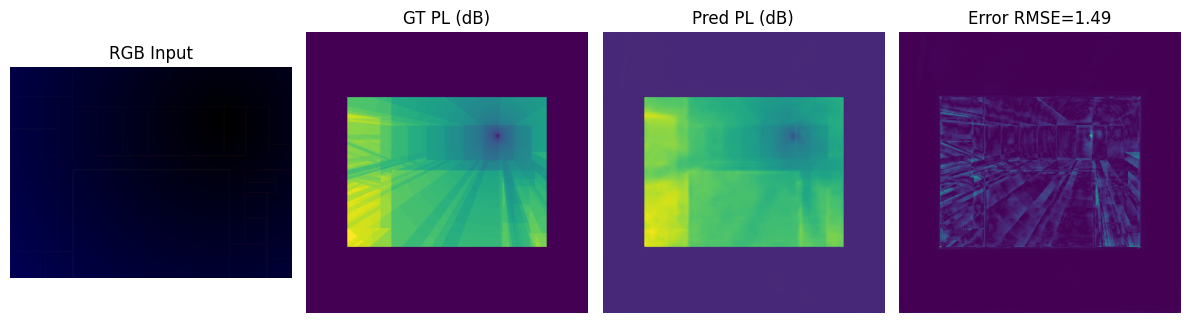

In [ ]:
# CODIGO DE CARGA Y VALIDACIÓN DEL MODELO

import os
import json
import cv2
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# ----------------------------------------------
# 1. Montar Google Drive y definir rutas
# ----------------------------------------------
from google.colab import drive

drive.mount('/content/drive2', force_remount=True)

dataset_root = "/content/drive2/MyDrive/ICASSP2025_Dataset"
model_path   = os.path.join(dataset_root, 'enhanced_deep_boost_unet_bike2.h5')
inputs_path  = os.path.join(dataset_root, "Inputs/Task_2_ICASSP")
outputs_path = os.path.join(dataset_root, "Outputs/Task_2_ICASSP")
ext_path     = os.path.join(dataset_root, 'extremos.json')
figs_dir     = os.path.join(dataset_root, 'figs_validation')
os.makedirs(figs_dir, exist_ok=True)

# Cargar extremos
with open(ext_path, 'r') as f:
    data    = json.load(f)
    ext_in  = {'min': tuple(data['rgb_min']), 'max': tuple(data['rgb_max'])}
    ext_out = {'min': data['pl_min'],      'max': data['pl_max']}

# ----------------------------------------------
# 2. CoordConv grid (512×512)
# ----------------------------------------------
coords         = np.linspace(-1, 1, 512)
grid_y, grid_x = np.meshgrid(coords, coords, indexing='ij')
coord_channels = np.stack([grid_x, grid_y], axis=-1)

# ----------------------------------------------
# 3. Funciones de padding/unpadding
# ----------------------------------------------
def pad_crop_with_info(img, pad_val=0):
    H, W = img.shape[:2]
    # altura
    if H >= 512:
        y0 = (H - 512)//2
        top = -y0
        img_p = img[y0:y0+512, :]
    else:
        pt = (512 - H)//2; pb = 512 - H - pt
        img_p = cv2.copyMakeBorder(img, pt, pb, 0, 0,
                                   cv2.BORDER_CONSTANT, value=pad_val)
        top = pt
    # anchura
    H2, W2 = img_p.shape[:2]
    if W2 >= 512:
        x0 = (W2 - 512)//2
        left = -x0
        img_pc = img_p[:, x0:x0+512]
    else:
        pl = (512 - W2)//2; pr = 512 - W2 - pl
        img_pc = cv2.copyMakeBorder(img_p, 0, 0, pl, pr,
                                    cv2.BORDER_CONSTANT, value=pad_val)
        left = pl
    return img_pc, (top, left)

def unpad(img, pads):
    pt, pl = pads
    h, w = img.shape[:2]
    start_y = 0 if pt>=0 else -pt
    end_y   = h - pt if pt>=0 else h + pt
    start_x = 0 if pl>=0 else -pl
    end_x   = w - pl if pl>=0 else w + pl
    return img[start_y:end_y, start_x:end_x]

# ----------------------------------------------
# 4. Normalización / Denormalización
# ----------------------------------------------
def normalize_rgb(img, ext):
    mi, ma = np.array(ext['min'], np.float32), np.array(ext['max'], np.float32)
    return np.clip((img.astype(np.float32) - mi) / (ma - mi), 0, 1)

def normalize_gray(img, ext):
    return np.clip((img.astype(np.float32) - ext['min']) / (ext['max'] - ext['min']), 0, 1)

def denormalize_gray(normed, ext):
    return normed * (ext['max'] - ext['min']) + ext['min']

# ----------------------------------------------
# 5. Preprocesado de una imagen
# ----------------------------------------------
def process_image(pi, pg, ext_in, ext_out, rate=0.005):
    # Leer imagen original
    im0 = cv2.cvtColor(cv2.imread(pi), cv2.COLOR_BGR2RGB)
    pl0 = cv2.imread(pg, cv2.IMREAD_GRAYSCALE)
    H0, W0 = pl0.shape

    # Muestreo aleatorio sobre tamaño original
    N0 = H0 * W0
    K  = int(N0 * rate)
    flat = np.zeros(N0, np.float32)
    flat[np.random.choice(N0, K, replace=False)] = 1
    mask0 = flat.reshape(H0, W0)

    # Pad/crop imágenes y máscara al tamaño 512
    im_p,   pads_rgb = pad_crop_with_info(im0, pad_val=0)
    pl_p,   pads_pl  = pad_crop_with_info(pl0, pad_val=ext_out['min'])
    mask_p, pads_m   = pad_crop_with_info(mask0, pad_val=0)

    # Normalizar
    rgb    = normalize_rgb(im_p, ext_in)
    y_full = normalize_gray(pl_p, ext_out)

    # Sparse (solo enmascarado)
    sparse = y_full * mask_p

    # Ensamble canales: rgb(3), sparse(1), mask(1), coords(2)
    x = np.concatenate([rgb, sparse[...,None], mask_p[...,None], coord_channels], axis=-1)
    return x.astype(np.float32), y_full[...,None].astype(np.float32), mask_p

# ----------------------------------------------
# 6. Construcción del modelo (idéntico al entrenamiento)
# ----------------------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

class SelfAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.q     = layers.Conv2D(filters//8, 1, padding='same')
        self.k     = layers.Conv2D(filters//8, 1, padding='same')
        self.v     = layers.Conv2D(filters,     1, padding='same')
        self.gamma = self.add_weight(shape=(), initializer='zeros', trainable=True)
    def call(self, x):
        B,H,W,C = tf.shape(x)[0], x.shape[1], x.shape[2], x.shape[3]
        f = tf.reshape(self.q(x), [B,-1,C//8])
        g = tf.reshape(self.k(x), [B,-1,C//8])
        h = tf.reshape(self.v(x), [B,-1,C])
        att = tf.nn.softmax(tf.matmul(f, g, transpose_b=True), axis=-1)
        o   = tf.matmul(att, h)
        o   = tf.reshape(o, [B,H,W,C])
        return self.gamma * o + x

def aspp_module(x, filters, rates=[1,6,12,18]):
    convs = [layers.Conv2D(filters,1,padding='same',activation='relu')(x)]
    for r in rates:
        convs.append(layers.Conv2D(filters,3,dilation_rate=r,padding='same',activation='relu')(x))
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1,1,x.shape[-1]))(pool)
    pool = layers.Conv2D(filters,1,padding='same',activation='relu')(pool)
    pool = layers.UpSampling2D((x.shape[1],x.shape[2]),interpolation='bilinear')(pool)
    convs.append(pool)
    return layers.Conv2D(filters,1,padding='same',activation='relu')(layers.Concatenate()(convs))

def build_model():
    filters = [16,32,64,128,256,512,1024]
    inp     = layers.Input((512,512,7))
    skips   = []
    x       = inp
    # Encoder
    for f in filters[:-1]:
        x = conv_block(x, f)
        skips.append(x)
        x = layers.MaxPool2D()(x)
    # Bottleneck
    b  = aspp_module(x, filters[-1])
    b  = SelfAttention(filters[-1])(b)
    b  = SelfAttention(filters[-1])(b)
    x  = b
    # Decoder
    for i, f in enumerate(reversed(filters[:-1])):
        x = layers.Conv2DTranspose(f,3,strides=2,padding='same')(x)
        x = layers.Concatenate()([x, skips[-i-1]])
        x = conv_block(x, f)
    # Heads
    boost = layers.Conv2D(1,1, name='boost_map')(x)
    sr    = layers.Conv2D(64,3,padding='same',activation='relu')(boost)
    sr    = layers.Conv2D(32,3,padding='same',activation='relu')(sr)
    out   = layers.Conv2D(1,3,padding='same',activation='linear', name='boost_map_sr')(sr)
    return Model(inp, out)

# Cargar modelo
model = build_model()
model.load_weights(model_path)
print("Modelo cargado correctamente.")

# ----------------------------------------------
# 7. Loop de validación
# ----------------------------------------------
files = sorted(os.listdir(inputs_path))
rmse_list, time_list = [], []

for fname in files:
    pi, pg = os.path.join(inputs_path, fname), os.path.join(outputs_path, fname)
    x, y_true, mask = process_image(pi, pg, ext_in, ext_out)

    t0 = time.time()
    y_pred = model.predict(x[None], verbose=0)[0,...,0]
    dt     = time.time() - t0

    # Desnormalizar
    y_pr_db = denormalize_gray(y_pred, ext_out)
    y_gt_db = denormalize_gray(y_true[...,0], ext_out)

    # RMSE en píxeles no muestreados
    unseen = (mask == 0)
    rmse_u = np.sqrt(np.mean((y_pr_db[unseen] - y_gt_db[unseen])**2))

    rmse_list.append(rmse_u)
    time_list.append(dt)

    # Guardar comparación
    fig, axs = plt.subplots(1,4,figsize=(12,4))
    imgs   = [cv2.cvtColor(cv2.imread(pi),cv2.COLOR_BGR2RGB), y_gt_db, y_pr_db, np.abs(y_pr_db-y_gt_db)]
    titles = ['RGB Input','GT PL (dB)','Pred PL (dB)', f'Error RMSE={rmse_u:.2f}']
    for ax, im, ti in zip(axs, imgs, titles):
        ax.axis('off')
        if im.ndim == 2:
            ax.imshow(im, cmap='viridis')
        else:
            ax.imshow(im)
        ax.set_title(ti)
    fig.tight_layout()
    fig.savefig(os.path.join(figs_dir, fname.replace('.png','.jpg')), dpi=150)
    plt.close(fig)

    print(f"{fname} -> RMSE_unseen: {rmse_u:.4f} dB, time: {dt:.3f}s")

# ----------------------------------------------
# 8. Resumen Global
# ----------------------------------------------
print("\n===== RESUMEN GLOBAL =====")
print(f"Total imágenes:       {len(rmse_list)}")
print(f"RMSE medio:           {np.mean(rmse_list):.4f} dB")
print(f"Desviación RMSE:      {np.std(rmse_list):.4f} dB")
print(f"Tiempo inferencia:    {np.mean(time_list):.3f}s")
